In [173]:
import pygad
import numpy
import pandas as pd


In [174]:
class ORD:
    def __init__(self, path, deadline_scope, size, tuning_values, filter_value, filter=None):
        self.deadline_scope = deadline_scope
        self.ordplan = pd.read_csv(path, header=None)
        self.filter = True if filter is None else filter
        self.size = size
        self.tuning_values = tuning_values
        self.filter_value = filter_value

    def prep(self):
        orders = self.ordplan

        #เอาไซส์กระดาษมาหารกับปริมาณการตัด เช่น กระดาษ 63 ถ้าตัดสองครั้งจได้ ~31 แล้วบันทึกเก็บไว้
        selected_values = self.size / self.tuning_values
        for i, row in orders.iterrows():
            diff = abs(selected_values - row["ตัดกว้าง"])
            orders.loc[i, "diff"] = diff

        #โดยออเดอร์ที่สามารถนำมาคู่กันได้ สำหรับกระดาษไซส์นี้ จะมีขนาดไม่เกิน 31(+-filter value) โดย filter value คือค่าที่กำหนดเอง
        new_orders = orders
        if self.filter:
            new_orders = (
                orders[orders["diff"] < self.filter_value].sort_values(by="ตัดกว้าง").reset_index(drop=True)
            )
        # print(new_orders)

        init_order = new_orders.iloc[0]

        temp = []

        #filter โดนยึดจากอันแรก
        # for i, order in new_orders.iterrows():
        #     if all(init_order[i] == order[i] for i in [2, 3, 4, 5, 6, 7, 11]):
        #         # if init_order[11] == order[11]:
        #         temp.append(order)

        temp = new_orders

        temp = pd.DataFrame(temp)

        return temp

    def get(self):
        ordplan = self.ordplan

        col_to_drop = (
            list(range(9, 12))
            + list(range(13, 14))
            + list(range(15, 18))
            + list(range(19, 26))
        )
        ordplan = ordplan.drop(columns=col_to_drop, axis=1)

        col = [
            "กำหนดส่ง",
            "แผ่นหน้า",
            "ลอน C",
            "แผ่นกลาง",
            "ลอน B",
            "แผ่นหลัง",
            "จำนวนชั้น",
            "ตัดกว้าง",
            "ตัดยาว",
            "เลขที่ใบสั่งขาย",
            "จำนวนสั่งขาย",
            "ประเภททับเส้น",
        ]
        ordplan.columns = col

        new_col = ["เลขที่ใบสั่งขาย"] + [
            col for col in ordplan.columns if col != "เลขที่ใบสั่งขาย"
        ]
        ordplan = ordplan.reindex(columns=new_col)
        ordplan["เลขที่ใบสั่งขาย"] = (
            ordplan["เลขที่ใบสั่งขาย"].astype(str).str.replace("121811", "x")
        )

        ordplan = ordplan[
            (ordplan["ตัดกว้าง"] != 0) & (ordplan["ตัดยาว"] != 0)
        ]  # filter out zero values -> index misaligned

        ordplan["ตัดกว้าง"] = round(ordplan["ตัดกว้าง"] / 25.4, 4)
        ordplan["ตัดยาว"] = round(ordplan["ตัดยาว"] / 25.4, 4)

        ordplan["จำนวนสั่งขาย"] = ordplan["จำนวนสั่งขาย"].str.replace(
            ",", ""
        )  # fix error values ex. 10,00 -> 1000
        ordplan.fillna(0, inplace=True)  # fix error values ex. , -> NA
        ordplan["จำนวนสั่งขาย"] = ordplan["จำนวนสั่งขาย"].astype(int)  # turns str -> int

        if self.deadline_scope >= 0:
            deadline = ordplan["กำหนดส่ง"].iloc[self.deadline_scope]
            ordplan = ordplan[ordplan["กำหนดส่ง"] == deadline]
        ordplan = ordplan.reset_index(drop=True)

        self.ordplan = ordplan

        return self.prep()

    def calculate_trim_and_roll(width):
        roll_paper = [68, 73, 75, 79, 82, 85, 88, 91, 95, 97]
        trim_min = 1
        trim_max = 3
        trim = [paper - width for paper in roll_paper]
        valid_trim_values = [t for t in trim if trim_min <= t <= trim_max]

        if valid_trim_values:
            roll = roll_paper[trim.index(valid_trim_values[0])]
            return valid_trim_values[0], int(roll)
        else:
            return None, None

    def calculate_roll(width):
        roll_paper = [68, 73, 75, 79, 82, 85, 88, 91, 95, 97]
        trim_min = 1
        trim_max = 3
        roll = None
        for i in range(1, 4):
            trim = [paper - width * i for paper in roll_paper]
            valid_trim_values = [t for t in trim if trim_min <= t <= trim_max]

            if valid_trim_values:
                roll = roll_paper[trim.index(valid_trim_values[0])]

        return roll

    def calculate_roll_tuning(width, tuning_values):
        roll_paper = [68, 73, 75, 79, 82, 85, 88, 91, 95, 97]
        trim_min = 1
        trim_max = 3
        roll = None
        trim = [paper - width * tuning_values for paper in roll_paper]
        valid_trim_values = [t for t in trim if trim_min <= t <= trim_max]

        if valid_trim_values:
            roll = roll_paper[trim.index(valid_trim_values[0])]
        return roll

    def calculate_roll_and_width(paper, width):
        trim_min = 1
        trim_max = 3
        if trim_min <= paper - width <= trim_max:
            return False
        return True

    def check_roll_compat(self, var, i, orders, PAPER_SIZE):
        if var:  # ถ้า var = 0 False
            if ORD.calculate_roll_and_width(
                PAPER_SIZE, 2 * orders.loc[i, "ตัดกว้าง"]
            ):  # ถ้า width *2 แล้วผ่าน False
                if ORD.calculate_roll_and_width(
                    PAPER_SIZE, 3 * orders.loc[i, "ตัดกว้าง"]
                ):  # ถ้า width *3 แล้วผ่าน False
                    if ORD.calculate_roll_and_width(
                        PAPER_SIZE, 4 * orders.loc[i, "ตัดกว้าง"]
                    ):  # ถ้า width *4 แล้วผ่าน False
                        if ORD.calculate_roll_and_width(
                            PAPER_SIZE, 5 * orders.loc[i, "ตัดกว้าง"]
                        ):  # ถ้า width *5 แล้วผ่าน False
                            if ORD.calculate_roll_and_width(
                                PAPER_SIZE, 6 * orders.loc[i, "ตัดกว้าง"]
                            ):  # ถ้า width *6 แล้วผ่าน False ex. 4*6 = 24 > 22-24 = -2
                                return abs(PAPER_SIZE * 2)
        return 0


In [175]:
class GA:
    def __init__(self, orders, size, num_generations, showOutput=None, save_solutions=None, showZero=None):
        self.orders = orders
        self.PAPER_SIZE = size
        self.showOutput = False if showOutput is None else showOutput
        self.save_solutions = False if save_solutions is None else save_solutions
        self.showZero = False if showZero is None else showZero

        self.num_generations = num_generations
        # num_parents_mating = len(orders)
        # self.num_parents_mating = int((orders['จำนวนสั่งขาย'].median()/100 + size/100)/2)
        self.num_parents_mating = 60

        # sol_per_pop = len(orders)*2
        # self.sol_per_pop =  int(orders['จำนวนสั่งขาย'].median()/100 + size/100)
        self.sol_per_pop = 120
        self.num_genes = len(self.orders)

        self.init_range_low = 0
        self.init_range_high = 2
        # self.init_range_high = abs(int(orders['จำนวนสั่งขาย'].median()/100 + size/100 - len(orders)*tuning_parameters))

        self.parent_selection_type = "tournament"
        # rws (for roulette wheel selection)
        # rank (for rank selection)
        # tournament (for tournament selection) - the best
        # sus (chat suggestion, stochastic_universal_selection)

        # crossover_type = "two_points"
        self.crossover_type = "uniform"  # - the best
        # crossover_type = "single_point"

        self.mutation_type = "random"
        self.mutation_percent_genes = 10
        # mutation_type = "adaptive"
        # mutation_percent_genes = (10,20)
        self.gene_type = int

        self.model = pygad.GA(
            num_generations=self.num_generations,
            num_parents_mating=self.num_parents_mating,
            fitness_func=self.fitness_function,
            sol_per_pop=self.sol_per_pop,
            num_genes=self.num_genes,
            parent_selection_type=self.parent_selection_type,
            gene_type=self.gene_type,
            init_range_low=self.init_range_low,
            init_range_high=self.init_range_high,
            crossover_type=self.crossover_type,
            mutation_type=self.mutation_type,
            mutation_percent_genes=self.mutation_percent_genes,
            on_generation=self.on_gen,
            save_solutions=self.save_solutions
        )

    def fitness_function(self, ga_instance, solution, solution_idx):
        penalty = 0
        orders = self.orders
        PAPER_SIZE = self.PAPER_SIZE
        penalty_value = 1000

        for i, var in enumerate(solution):
            if var < 0:  # ถ้ามีค่าน้อยกว่า 0 penalty > กันติดลบ
                penalty += penalty_value

        if sum(solution) > 6:  # ถ้าผลรวมมีค่ามากกว่า 6 penalty > outได้สูงสุด 6 out ต่อรอบ
            penalty += penalty_value*sum(solution)

        if solution[solution >= 1].size > 2:  # out สูงสุด 2 ครั้ง ต่อออร์เดอร์
            penalty += penalty_value

        output = numpy.sum(solution * orders["ตัดกว้าง"])  # ผลรวมของตัดกว้างทั้งหมด

        if output > PAPER_SIZE:  # ถ้าผลรวมมีค่ามากกว่า roll กำหนดขึ้น penalty
            penalty += penalty_value

        fitness_values = -PAPER_SIZE + output  # ผลต่างของกระดาษที่มีกับออเดอร์ ยิ่งเยอะยิ่งดี

        if abs(fitness_values) <= 1.22:  # ถ้าผลรวมมีค่าน้อยกว่า 1.22 penalty > เงื่อนไขบริษัท
            penalty += penalty_value

        return fitness_values - penalty  # ลบด้วย penalty

    def on_gen(self, ga_instance):
        orders = self.orders

        solution = ga_instance.best_solution()[0]

        output = pd.DataFrame(
            {
                "order_number": orders["เลขที่ใบสั่งขาย"],
                "num_layers": orders["จำนวนชั้น"],
                "cut_width": orders["ตัดกว้าง"],
                "type": orders["ประเภททับเส้น"],
                "diff": orders["diff"],
                "out": solution,
            }
        )

        if not self.showZero:
            output = output[output["out"] >= 1]
        output = output.reset_index(drop=True)

        self.fitness_values = ga_instance.best_solution()[1]
        self.output = output

        if self.showOutput:
            self.show(ga_instance, output)

    def show(self, ga_instance, output):
        PAPER_SIZE = self.PAPER_SIZE
        print("Generation : ", ga_instance.generations_completed)
        print("Solution :")

        with pd.option_context(
            "display.max_columns",
            None,
            "display.width",
            None,
            "display.colheader_justify",
            "left",
        ):
            print(output.to_string(index=False))

        print("Roll :", PAPER_SIZE)
        print("Used :", PAPER_SIZE + self.fitness_values)
        print("Trim :", abs(self.fitness_values))
        print("\n")

    def get(self):
        return self.model

c:\Users\user\Desktop\paper_cutting_project\.venv\Lib\site-packages\pygad\pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")


Generation :  1
Solution :
order_number  num_layers  cut_width type  diff   out
x26621       5           26.0236    N    7.9764 1   
x39268       3           26.1024    Y    7.8976 1   
x34008       3           26.1024    Y    7.8976 1   
x28329       3           26.1024    Y    7.8976 1   
x29302       3           26.1024    Y    7.8976 1   
x29068       3           26.1024    Y    7.8976 1   
x37458       3           26.1024    Y    7.8976 1   
x34916       3           26.1417    X    7.8583 1   
x39445       3           26.1417    X    7.8583 1   
x34458       3           26.1417    X    7.8583 1   
x27252       3           26.1417    X    7.8583 1   
x32921       3           26.1417    X    7.8583 1   
x28200       3           26.1417    X    7.8583 1   
x34917       3           26.1417    X    7.8583 1   
x26202       3           26.1417    X    7.8583 1   
x29133       3           26.1417    X    7.8583 1   
x36258       3           26.1417    X    7.8583 1   
x37173       3     

c:\Users\user\Desktop\paper_cutting_project\.venv\Lib\site-packages\pygad\visualize\plot.py:109: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  matplotlib.pyplot.legend()


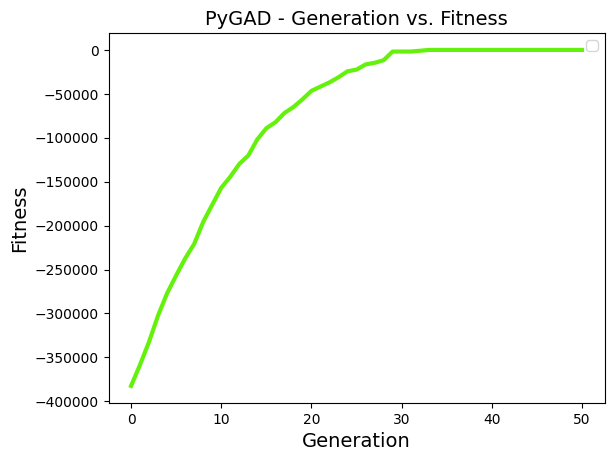

In [180]:
ROLL_PAPER = [68, 73, 75, 79, 82, 85, 88, 91, 95, 97]


def handle_optimization():
    size_value = ROLL_PAPER[0]
    file_path = './data/true_ordplan.csv'

    orders = ORD(file_path, deadline_scope=-1, filter=True, filter_value=8, size=size_value, tuning_values=2).get()
    
    ga_instance = GA(orders, size=size_value, num_generations=50,showOutput=True,save_solutions=False,showZero=False)
    ga_instance.get().run()
    ga_instance.get().plot_fitness()

    
handle_optimization()